# Exploratory Data Analysis (EDA)

### Preparations

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.sql.functions as sf

plt.style.use('bmh')
pd.options.display.max_columns = 500

In [3]:
poms = spark.read.parquet("gs://dataproc-jupyter-eileen.npo-data.nl/data/poms_stream/")
print(poms.count())
poms.printSchema()

83886
root
 |-- age_rating: string (nullable = true)
 |-- credits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- family_name: string (nullable = true)
 |    |    |-- given_name: string (nullable = true)
 |    |    |-- role: string (nullable = true)
 |-- genres: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- terms: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- mid: string (nullable = true)
 |-- broadcaster: string (nullable = true)
 |-- description: string (nullable = true)
 |-- title: string (nullable = true)
 |-- sub: string (nullable = true)
 |-- seriesRef: string (nullable = true)



In [4]:
def replace(column, value):
    return sf.when(sf.size(column) > value, column).otherwise(sf.lit(None))
def replace2(column, value):
    return sf.when(column != value, column).otherwise(sf.lit(None))

poms = poms.withColumn("credits", replace(sf.col("credits"), 0))
poms = poms.withColumn("genres", replace(sf.col("genres"), 0))
poms = poms.withColumn("sub", replace2(sf.col("sub"), ""))

df = poms.toPandas()

In [5]:
df = df.rename(columns = {"sub" : "subtitles", "seriesRef" : "series_reference"})
df = df.reindex(sorted(df.columns), axis=1)
df.head()

,age_rating,broadcaster,credits,description,genres,mid,series_reference,subtitles,title
0,ALL,AVTR,"[(van Osch, Frank, DIRECTOR)]",Regisseur Frank van Osch ging met fotograaf Ja...,"[(3.0.1.8.24, [Documentaire, Kunst/cultuur])]",AT_2054679,POMS_S_AVRO_096892,888 terugkerend thema in het werk van fotograa...,Close Up
1,12,AVTR,"[(van Rijn, Pieter, DIRECTOR), (Roelfsema, Mar...",Wolfs en Eva krijgen een zaak waarbij 2 lijken...,"[(3.0.1.3.10, [Serie, Spanning])]",AT_2061068,AT_2037214,888 mooi! u werkt daar belangeloos aan mee? 20...,Flikken Maastricht
2,ALL,AVTR,"[(Niehe, Ivo, PRESENTER)]",Een gesprek met Rob Scholte en een eerbetoon a...,"[(3.0.1.6, [Amusement])]",AT_2066759,AT_2048922,888 goedenavond. straks het levensverhaal van ...,TV Show
3,ALL,AVTR,"[(van Brakel, Maurits, ACTOR), (Kroes, Olie, A...",Lieke moet van haar moeder netjes blijven. Dat...,"[(3.0.1.1.3, [Jeugd, Serie])]",AT_2071463,AT_2049785,"888 oeh! o, doe dat maar niet. hoi. een hele g...",Mees Kees
4,ALL,AVTR,"[(Caspers, Charlotte, PRESENTER), (Dik, Joris,...",Op 12 oktober 1654 kwam Fabritius om het leven...,"[(3.0.1.7.24, [Informatief, Kunst/cultuur])]",AT_2083070,AT_2051673,888 door het maken van een reconstructie probe...,Het geheim van de Meester


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83886 entries, 0 to 83885
Data columns (total 9 columns):
age_rating          83886 non-null object
broadcaster         83886 non-null object
credits             30541 non-null object
description         70836 non-null object
genres              72427 non-null object
mid                 83886 non-null object
series_reference    83886 non-null object
subtitles           35068 non-null object
title               83886 non-null object
dtypes: object(9)
memory usage: 5.8+ MB


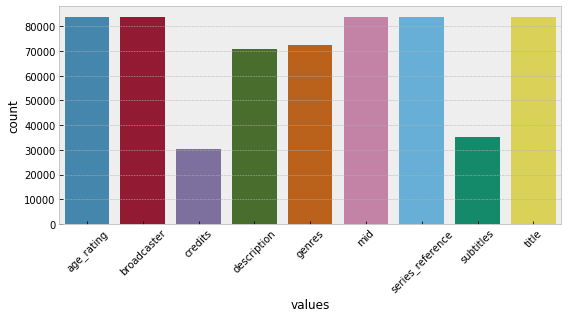

In [7]:
test = df.isna().sum()
df2 = pd.DataFrame({'values':test.index, 'na_count':test.values})
df2['count'] = poms.count() - df2['na_count']

plt.figure(figsize = (9,4))
ax = sns.barplot(x='values', y ='count', data=df2)#.set_title('Count of non-NaN values')
plt.xticks(rotation=45)
plt.show()

### Visualizing data distribution

In [8]:
df['age_rating'] = df['age_rating'].astype('category')
df['credits'] = df['credits'].astype('string').astype('category')
df['genres'] = df['genres'].astype('string').astype('category')
df['broadcaster'] = df['broadcaster'].astype('category')
df.dtypes

age_rating          category
broadcaster         category
credits             category
description           object
genres              category
mid                   object
series_reference      object
subtitles             object
title                 object
dtype: object

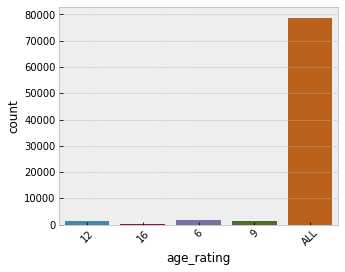

In [9]:
plt.figure(figsize = (5,4))
ax = sns.countplot(x="age_rating", data=df)
plt.xticks(rotation=45)
plt.show()

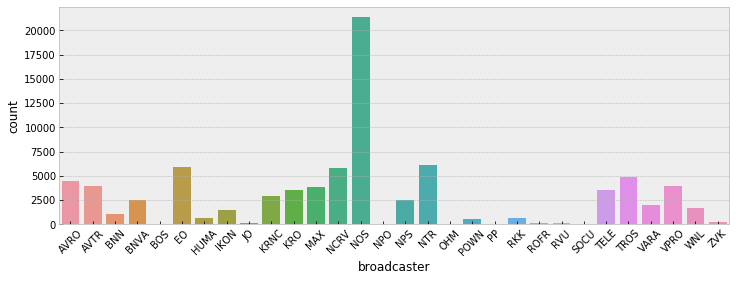

In [10]:
plt.figure(figsize = (12,4))
ax = sns.countplot(x="broadcaster", data=df)
plt.xticks(rotation=45)
plt.show()

## Text length (includes 0 values)

In [12]:
# amount of characters, not words
df['title_length'] = df.title.str.split().apply(len)
df['description'] = df['description'].fillna('')
df['description_length'] = df.description.str.split().apply(len)
df['title_length'] = df['title_length'].fillna(0)
df['description_length'] = df['description_length'].fillna(0)

In [52]:
print("Title length")
print("Mean " + str(df['title_length'].mean()))
print("Median " + str(df['title_length'].median()))
print("\nDescription length")
print("Mean " + str(df['description_length'].mean()))
print("Median " + str(df['description_length'].median()))

Title length
Mean 2.49010561953
Median 2.0

Description length
Mean 20.7481224519
Median 18.0


In [18]:
df['subtitles'] = df['subtitles'].fillna('')
df['sub_length'] = df['subtitles'].str.split().apply(len)
df['sub_length'] = df['sub_length'].fillna(0)

In [19]:
print("Mean " + str(df['sub_length'].mean()))
print("Median " + str(df['sub_length'].median()))

Mean 1038.59391317
Median 0.0


- Title, description and subtitle (character) length al have a skewed distribution

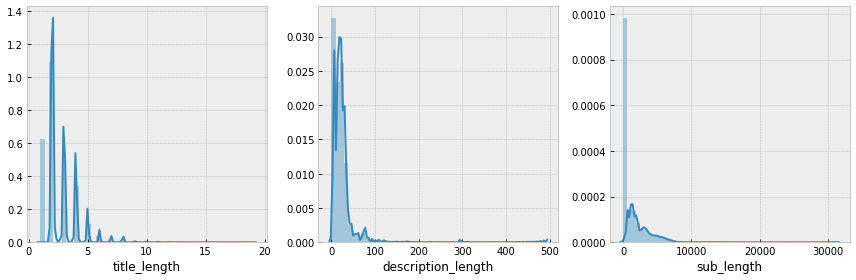

In [47]:
test = ['title_length', 'description_length', 'sub_length']
fig, ax = plt.subplots(1, 3, figsize = (12,4))

for i, ax in enumerate(fig.axes):
    if i < len(test):
        sns.distplot(df[test[i]], ax=ax)   
        #ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
    
fig.tight_layout()

### Broadcaster richness investigation

In [23]:
def length(df):
    sub_extra = []
    for index, row in df.iterrows():
        doc = row['description_length'] > 0
        sub_extra.append(doc)
    df['length'] = sub_extra

test = df.copy()
length(test)

In [24]:
broadcaster = df.broadcaster.unique().tolist()
pd_test = pd.DataFrame(broadcaster, columns=['broadcaster'])
true_ = []
false_ = []
count_ = []
for i in broadcaster:
    test2 = test[test['broadcaster'] == i]
    count = len(test2['length'])
    count_.append(count)
    true = sum(test2['length'] == True)
    false = sum(test2['length'] == False)
    true_.append(true)
    false_.append(false)
pd_test['count'] = count_
pd_test['true'] = true_
pd_test['false'] = false_
#pd_test

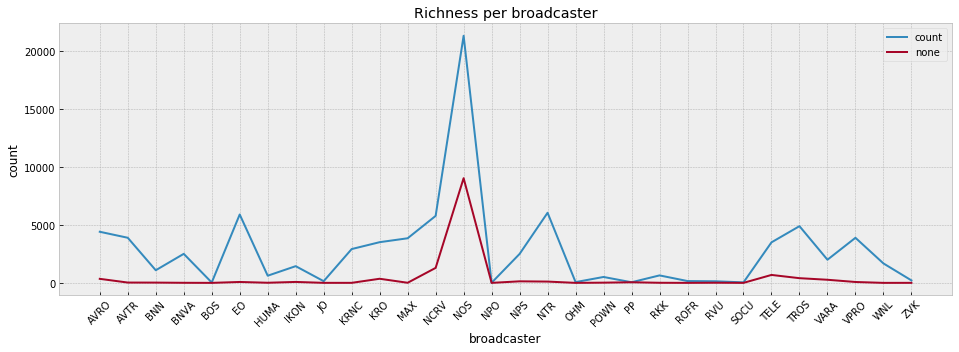

In [25]:
plt.figure(figsize = (16,5))
ax = sns.lineplot(x="broadcaster", y="count",data=pd_test, label="count")
#ax = sns.lineplot(x="broadcaster", y="true",data=pd_test, label="true")
ax = sns.lineplot(x="broadcaster", y="false",data=pd_test, label="none")
plt.xticks(rotation=45)
plt.title("Richness per broadcaster")
plt.ylabel("count")
plt.show()

### Series investigation

In [29]:
print(len(df.series_reference.unique()))
df.series_reference.value_counts()

NOSJournaal               10297
NOSJeugdjournaal           3088
AT_2046031                 2160
VPWON_1256937              2050
NOSJournaalgebarentolk     2023
KN_1676932                 1692
VPWON_1256934              1602
POMS_S_NCRV_059865         1474
AT_2037144                 1125
NOSjeugd0845geb            1099
VPWON_1257894              1038
POW_03333061                999
VARA_101377717              956
NOSSportRegulier            950
POW_03108338                932
NOSjnl2000                  836
KN_1677095                  782
VPWON_1246712               721
POMS_S_KRO_059857           696
POW_03108298                540
POMS_S_VARA_059932          501
VPWON_1257901               464
KN_1676721                  453
POW_03469040                435
VPWON_1259670               435
KN_1677083                  434
AT_2035122                  433
VPWON_1257896               421
POMS_S_AVRO_096997          421
VPWON_1256936               402
                          ...  
POMS_S_B

In [44]:
grouped = df.groupby('series_reference')
grouped_df = grouped.mean()
grouped_df

,title_length,description_length,sub_length
series_reference,,,
12Jnl0730n1,2.000000,2.785714,50.654762
12Jnl0730n2,4.000000,0.000000,50.963415
12Jnl0830n1,2.000000,2.821429,52.226190
12Jnl0830n2,2.000000,0.000000,51.695122
12stspEreVrijdag,4.000000,10.000000,0.000000
12stspSuperCup,4.400000,12.200000,0.000000
12stspVoetbal,3.000000,10.842105,427.842105
12stspVoetbalHH,3.000000,7.000000,0.000000
13Jnl1200n2,2.000000,0.000000,1174.000000


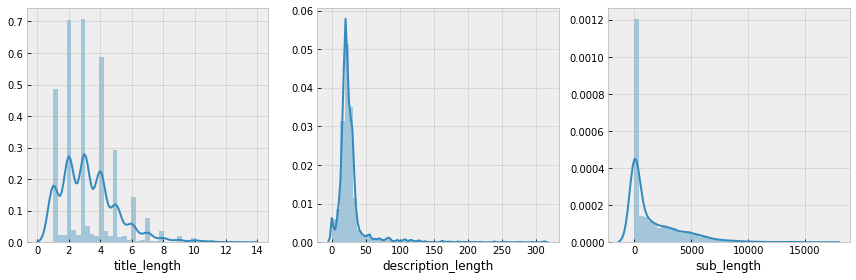

In [48]:
test = ['title_length', 'description_length', 'sub_length']
fig, ax = plt.subplots(1, 3, figsize = (12,4))

for i, ax in enumerate(fig.axes):
    if i < len(test):
        #ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.distplot(grouped_df[test[i]], ax=ax)    
    
fig.tight_layout()

In [53]:
print("Title length")
print("Mean " + str(grouped_df['title_length'].mean()))
print("Median " + str(grouped_df['title_length'].median()))
print("\nDescription length")
print("Mean " + str(grouped_df['description_length'].mean()))
print("Median " + str(grouped_df['description_length'].median()))
print("\nSubtitles length")
print("Mean " + str(grouped_df['sub_length'].mean()))
print("Median " + str(grouped_df['sub_length'].median()))

Title length
Mean 3.28597462119
Median 3.0

Description length
Mean 27.579924905
Median 22.0

Subtitles length
Mean 1687.02773121
Median 500.727020227
